In [719]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory.
import os
import json
import matplotlib.pyplot as plt#visualization
from collections import Counter
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns #visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization

import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE, SMOTE

from scipy.stats import shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, scorer, log_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, cohen_kappa_score
from sklearn.model_selection import KFold, GridSearchCV

# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation

import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold
from pylab import rcParams

rcParams['figure.figsize'] = 8, 5
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-whitegrid')

# Домашнее задание (часть 1)

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)

In [69]:
#скачал датасет отсюда https://www.kaggle.com/sumanoj23/dataset
df = pd.read_csv("training_g_b_new1.csv")

In [70]:
df.shape

(4102, 21)

In [71]:
df.head()

,user_id,target,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions
0,8468,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,1
1,4884,0,5,31,13,0,2,1,4,1,0,6,0,0,0,0,0,1,0,78,6
2,3483,0,3,24,0,0,1,0,0,0,0,19,0,2,0,4,3,2,3,86,6
3,9032,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1
4,1268,1,18,129,2,10,10,0,26,1,1,172,2,3,21,1,0,0,86,454,25


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4102 entries, 0 to 4101
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   user_id           4102 non-null   int64
 1   target            4102 non-null   int64
 2   account_detail_f  4102 non-null   int64
 3   pro_cat_f         4102 non-null   int64
 4   accessories_f     4102 non-null   int64
 5   view_order_f      4102 non-null   int64
 6   orders_f          4102 non-null   int64
 7   contact_us_f      4102 non-null   int64
 8   rewards_f         4102 non-null   int64
 9   rewards_cart_f    4102 non-null   int64
 10  deli_retrn_f      4102 non-null   int64
 11  shop_f            4102 non-null   int64
 12  prod_search_f     4102 non-null   int64
 13  goalkeeper_f      4102 non-null   int64
 14  loyalty_f         4102 non-null   int64
 15  prod_coulour_f    4102 non-null   int64
 16  clearance_f       4102 non-null   int64
 17  sale_f            4102 non-null  

2. сделать eda (как на занятии 6 с примером для оттока)

In [77]:
#целевая переменная и список признаков
target = 'target'
feauters = [df.columns[0]] + list(df.columns[2:])
feauters

['user_id',
 'account_detail_f',
 'pro_cat_f',
 'accessories_f',
 'view_order_f',
 'orders_f',
 'contact_us_f',
 'rewards_f',
 'rewards_cart_f',
 'deli_retrn_f',
 'shop_f',
 'prod_search_f',
 'goalkeeper_f',
 'loyalty_f',
 'prod_coulour_f',
 'clearance_f',
 'sale_f',
 'training_wear_f',
 'page_views',
 'sessions']

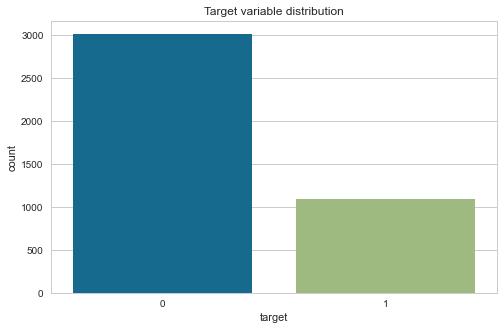

In [78]:
#Кол-во значений классов:
plt.figure(figsize=(8, 5))

sns.countplot(x=target, data=df)

plt.title('Target variable distribution')
plt.show()

Присутствует некоторый дисбаланс классов - возможно, придется их балансировать

In [79]:
df.corr()

,user_id,target,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions
user_id,1.000000,-0.140390,-0.145816,-0.156878,-0.094564,-0.097625,-0.081542,-0.072630,-0.120558,-0.089615,-0.096184,-0.183808,-0.175302,-0.114805,-0.094206,-0.020920,-0.125715,-0.152103,-0.179506,-0.177709,-0.190019
target,-0.140390,1.000000,0.174370,0.217046,0.178169,0.186133,0.147250,0.211665,0.191514,0.179146,0.200659,0.258442,0.242616,0.120402,0.167223,0.175308,0.139872,0.180615,0.271988,0.219347,0.202387
account_detail_f,-0.145816,0.174370,1.000000,0.606962,0.501863,0.677056,0.603691,0.401903,0.569683,0.489398,0.260302,0.625821,0.165042,0.394438,0.416268,0.536349,0.313921,0.470184,0.534487,0.687221,0.552152
pro_cat_f,-0.156878,0.217046,0.606962,1.000000,0.740534,0.469657,0.488775,0.358368,0.628197,0.475495,0.337830,0.895629,0.185784,0.617239,0.536175,0.756347,0.517167,0.616127,0.837325,0.916633,0.726113
accessories_f,-0.094564,0.178169,0.501863,0.740534,1.000000,0.455842,0.506303,0.291011,0.609793,0.426110,0.267078,0.681591,0.124509,0.393138,0.515265,0.530525,0.346942,0.574202,0.652627,0.695704,0.551897
view_order_f,-0.097625,0.186133,0.677056,0.469657,0.455842,1.000000,0.899959,0.282988,0.635455,0.448589,0.250069,0.512621,0.133979,0.334316,0.400979,0.286526,0.240653,0.537245,0.434142,0.540308,0.479510
orders_f,-0.081542,0.147250,0.603691,0.488775,0.506303,0.899959,1.000000,0.222706,0.730775,0.446783,0.255317,0.532033,0.106788,0.393986,0.419394,0.275421,0.202458,0.576788,0.457169,0.564981,0.499275
contact_us_f,-0.072630,0.211665,0.401903,0.358368,0.291011,0.282988,0.222706,1.000000,0.260005,0.216485,0.259571,0.409770,0.171854,0.224567,0.201185,0.404690,0.150277,0.219922,0.316575,0.396770,0.376988
rewards_f,-0.120558,0.191514,0.569683,0.628197,0.609793,0.635455,0.730775,0.260005,1.000000,0.745466,0.320550,0.676324,0.153590,0.420505,0.729080,0.403113,0.272865,0.602572,0.598514,0.658095,0.569097
rewards_cart_f,-0.089615,0.179146,0.489398,0.475495,0.426110,0.448589,0.446783,0.216485,0.745466,1.000000,0.248393,0.524749,0.125340,0.263413,0.703432,0.332762,0.283452,0.411184,0.455075,0.501535,0.404940


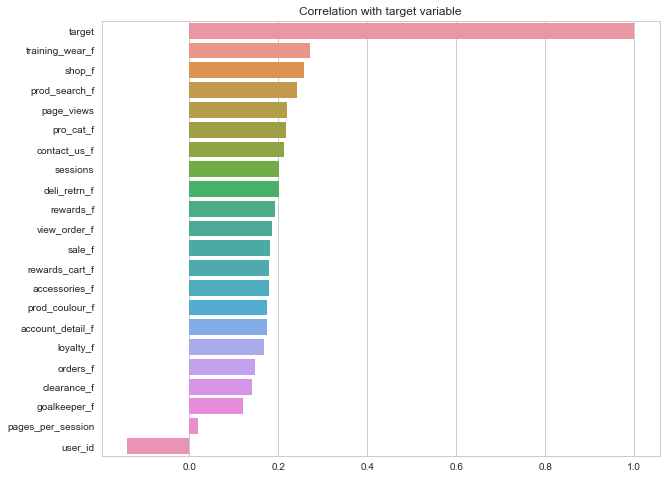

In [108]:
corr_with_target = df.corr().iloc[:, 1].sort_values(ascending=False)
xs = corr_with_target.values
ys = corr_with_target.index

plt.figure(figsize=(10, 8))

sns.barplot(x=xs, y=ys)

plt.title('Correlation with target variable')
plt.show()

Коррелируют с целевой переменной больше всего:

- training_wear_f
- shop_f
- prod_search_f

Посмотрим на числовые признаки:

In [84]:
def extend_describe_for_num_values(df, col_lst, target_name):
    #Функция возвращает доп.данные по признакам с таблицой describe: 
    # - дисперсию
    # - кол-во пустых значений
    # - кол-во уникальных значений
    # - корреляцию Пирсона с целевым признаком
    # - p-value по тесту Шапиро о нормальности распределения
    # - p-value по критерию Манна-Уитни о равных значениях мат. ожидайния между разными значениями классов целевого признака
    
    df_describe = df[col_lst].describe()
    df_desc_add = pd.DataFrame(columns=col_lst)
    for _ in range(5):
        df_desc_add = df_desc_add.append(pd.Series(), ignore_index=True)
    
    
    for v in col_lst:
        df_desc_add[v].iloc[[0]] = np.var(df[v])
        df_desc_add[v].iloc[[1]] = df[df[v].isnull()].shape[0]
        df_desc_add[v].iloc[[2]] = df[v].nunique()
        df_notna = df.loc[df[v].notna()]
        shapiro_p_value = shapiro(df_notna[v])[1]
        df_desc_add[v].iloc[[3]] = shapiro_p_value
        if shapiro_p_value < 0.05:
            v_target_0 = df_notna.loc[df_notna[target_name]==0, v]
            v_target_1 = df_notna.loc[df_notna[target_name]==1, v]
            df_desc_add[v].iloc[[4]] = mannwhitneyu(v_target_0, v_target_1)[1]
    
    df_corr = pd.DataFrame(df[col_lst + [target_name]].corr().iloc[:-1, -1]).T

    df_desc_add.rename(index={0:'var', 1:'null', 2:'nunique', 3:'shapiro p-value', 4:'mannw p-value'}, inplace=True)
    df_corr.rename(index={target_name:'corr'}, inplace=True)
    
    df2 = pd.concat([df_describe, df_desc_add, df_corr])
    
    return df2

In [85]:
extend_describe_for_num_values(df, feauters, target)

,user_id,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions
count,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102,4102
mean,5966.07,3.46392,27.0982,1.91078,0.30863,0.606777,0.204778,0.578498,0.0958069,0.114578,20.1082,0.471234,2.70673,0.334959,9.93784,0.423452,0.542906,8.87055,75.9661,4.73745
std,1919.21,8.69346,62.0715,9.32262,2.24956,4.48174,0.771345,3.23788,0.627219,0.558708,46.3563,2.19852,8.99297,2.38941,24.5957,2.5944,2.17049,26.0209,173.657,11.856
min,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
25%,4649.5,0,3,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,14,1
50%,5853.5,1,10,0,0,0,0,0,0,0,9,0,0,0,3,0,0,0,31,2
75%,7353.75,3,27.75,0,0,0,0,0,0,0,21,0,0,0,11,0,0,7,78,4
max,9325,151,1250,222,86,238,12,122,14,14,1011,40,197,59,688,103,65,590,3993,362
var,3.68245e+06,75.5578,3851.93,86.8901,5.05931,20.0811,0.594828,10.4813,0.393308,0.312079,2148.39,4.8323,80.8538,5.70789,604.802,6.72927,4.70989,676.922,30149.5,140.531
null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Все распределения не нормальные (Значение Критерия Шапиро-Уилка ниже порогового 𝑝 - 𝑣𝑎𝑙𝑢𝑒<0.05 ).
- По критерию Манна-Уитни видно, что только в признаке account_detail_f значения мат ожидания для 0 и 1 класса целевой переменной одинаковы. Остальные отличаются

Проверим визуально равенства мат.ожиданий:

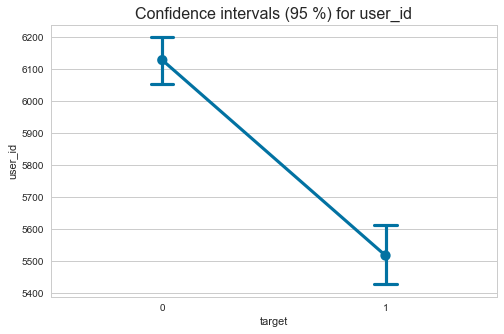

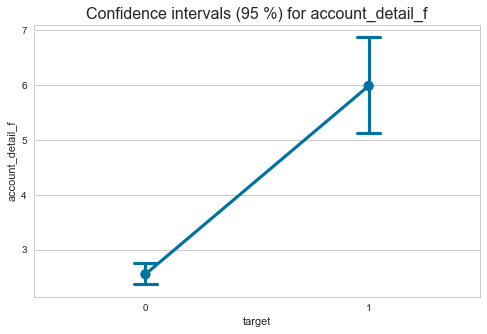

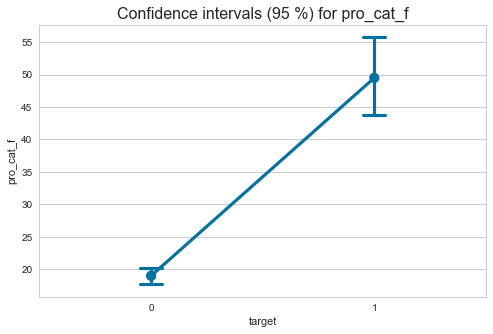

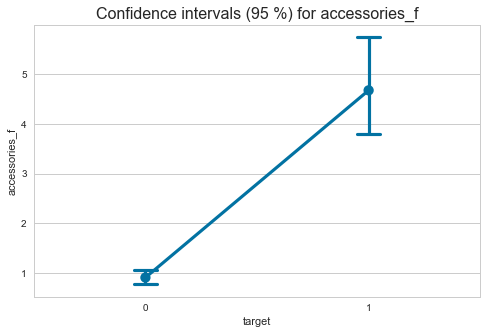

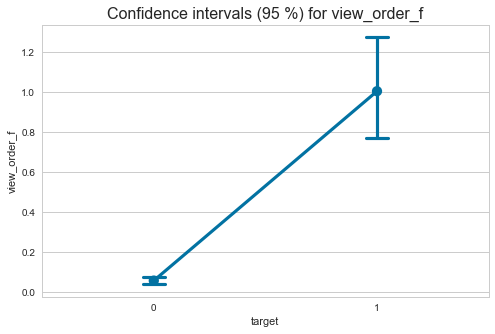

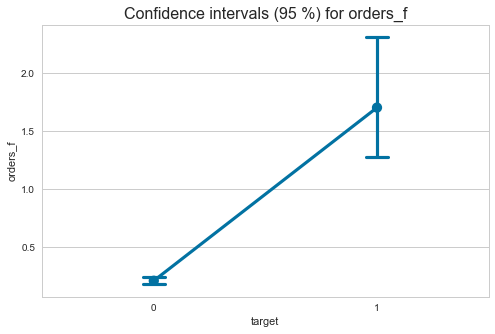

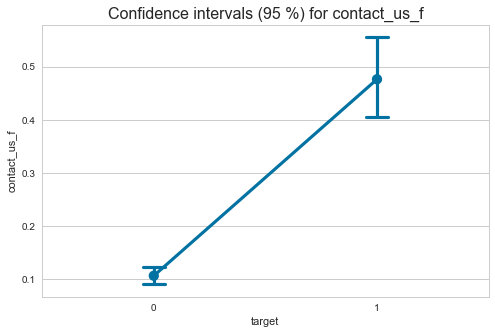

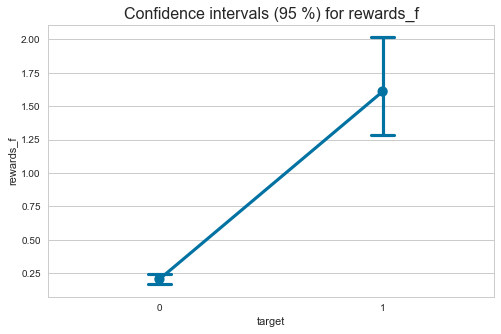

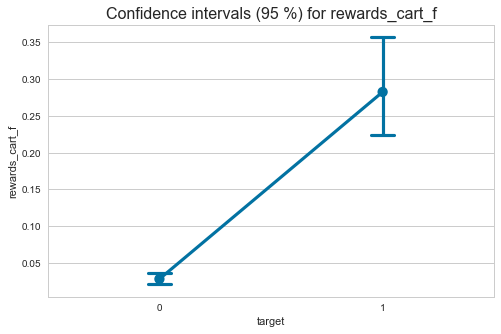

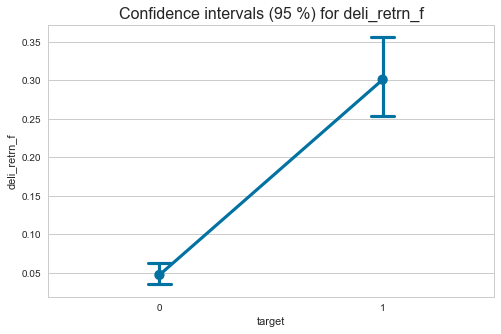

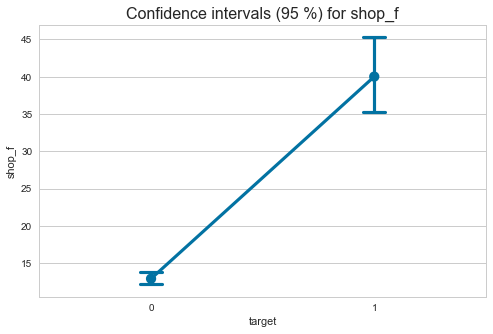

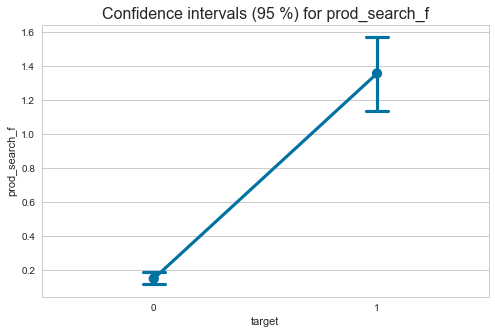

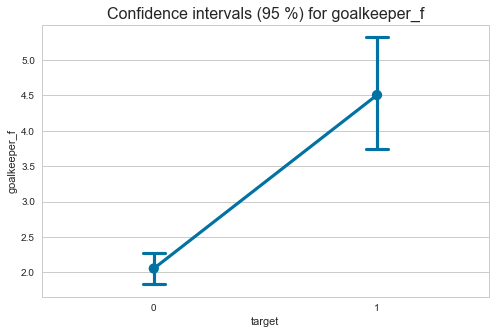

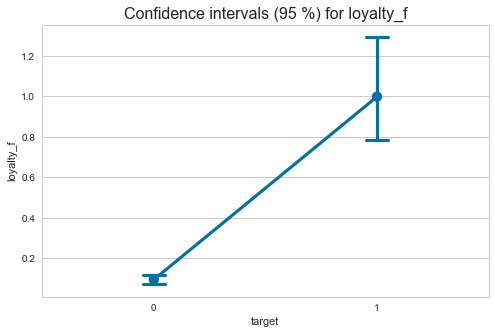

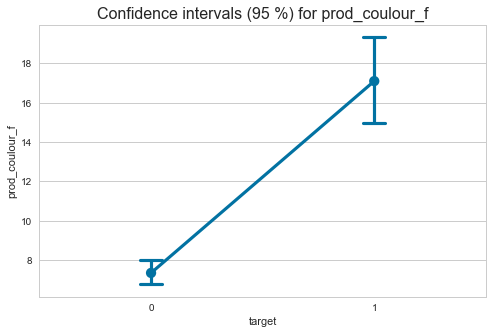

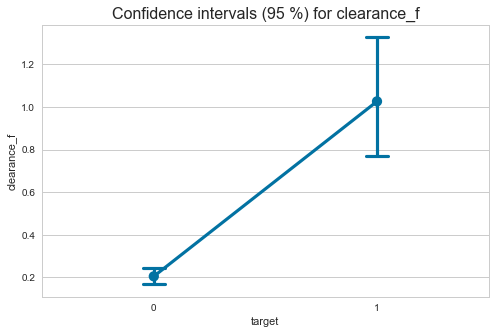

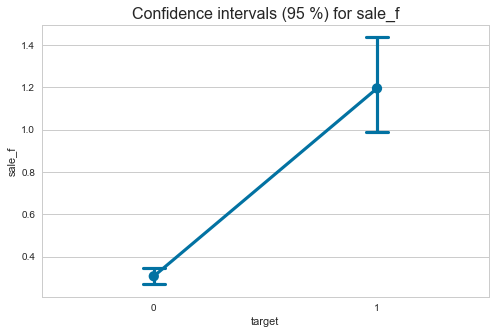

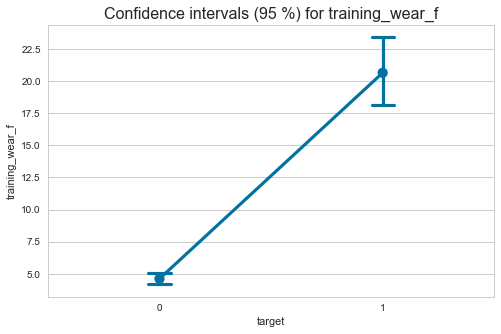

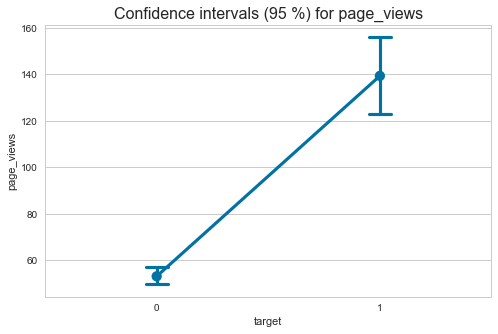

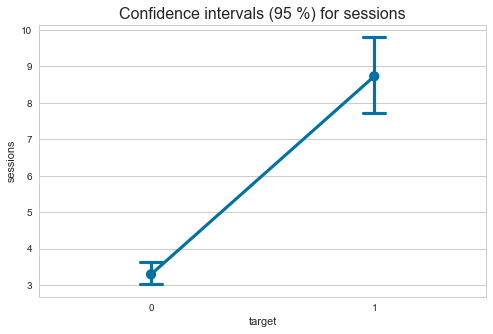

In [86]:
for v in feauters:
    df_v = df.loc[df[v].notna()]
    plt.figure(figsize=(8, 5))

    sns.pointplot(x=target, y=v, data=df_v, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {v}', fontdict={'fontsize': 16})
    plt.show()

Визуальный анализ показал, что в признаке account_detail_f мат. ожидания не равны

In [66]:
#function  for histogram for customer attrition types
def histogram(column) :
    trace1 = go.Histogram(x  = target1[column],
                          histnorm= "percent",
                          name = "Class 1 Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = target2[column],
                          histnorm = "percent",
                          name = "Class 0 customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution in customer attrition ",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [67]:
target1 = df[df[target] == 1]
target2 = df[df[target] == 0]

#for all categorical columns plot histogram    
for i in feauters:
    histogram(i)

3. сделать feature engineering

In [87]:
df.head()

,user_id,target,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions
0,8468,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,1
1,4884,0,5,31,13,0,2,1,4,1,0,6,0,0,0,0,0,1,0,78,6
2,3483,0,3,24,0,0,1,0,0,0,0,19,0,2,0,4,3,2,3,86,6
3,9032,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1
4,1268,1,18,129,2,10,10,0,26,1,1,172,2,3,21,1,0,0,86,454,25


Добавим pages_per_session - кол-во страниц за сессию

In [88]:
df['pages_per_session'] = df['page_views'] / df['sessions']

Добавим сумму разных признаков, приходящуюся на 1-го пользователя

In [143]:
agg_feauters = {
    'sessions': 'sum',
    'page_views': 'sum',
    'pro_cat_f': 'sum',
    'goalkeeper_f': 'sum',
    'prod_coulour_f': 'sum',
}
rename_agg_feauters = {
    'sessions': 'sessions_per_user',
    'page_views': 'page_views_per_user',
    'pro_cat_f': 'pro_cat_f_per_user',
    'goalkeeper_f': 'goalkeeper_f_per_user',
    'prod_coulour_f': 'prod_coulour_f_per_user',
}

In [144]:
group_1 = df.groupby('user_id', 
                    as_index=False).agg(agg_feauters).rename(columns=rename_agg_feauters)
df2 = pd.merge(df, group_1, on='user_id', how='left')
df2.head()

,user_id,target,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions,pages_per_session,sessions_per_user,page_views_per_user,pro_cat_f_per_user,goalkeeper_f_per_user,prod_coulour_f_per_user
0,8468,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,1,10.000000,1,10,3,0,1
1,4884,0,5,31,13,0,2,1,4,1,0,6,0,0,0,0,0,1,0,78,6,13.000000,6,78,31,0,0
2,3483,0,3,24,0,0,1,0,0,0,0,19,0,2,0,4,3,2,3,86,6,14.333333,6,86,24,2,4
3,9032,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,7.000000,1,7,0,0,0
4,1268,1,18,129,2,10,10,0,26,1,1,172,2,3,21,1,0,0,86,454,25,18.160000,25,454,129,3,1


Удалим признак user_id, который мы выразили через другие и посмотрим на корреляцию оставшихся признаков

In [145]:
df2.drop('user_id', axis=1, inplace=True)

In [146]:
#итоговый список признаков:
feauters = list(df2.columns[1:])
feauters

['account_detail_f',
 'pro_cat_f',
 'accessories_f',
 'view_order_f',
 'orders_f',
 'contact_us_f',
 'rewards_f',
 'rewards_cart_f',
 'deli_retrn_f',
 'shop_f',
 'prod_search_f',
 'goalkeeper_f',
 'loyalty_f',
 'prod_coulour_f',
 'clearance_f',
 'sale_f',
 'training_wear_f',
 'page_views',
 'sessions',
 'pages_per_session',
 'sessions_per_user',
 'page_views_per_user',
 'pro_cat_f_per_user',
 'goalkeeper_f_per_user',
 'prod_coulour_f_per_user']

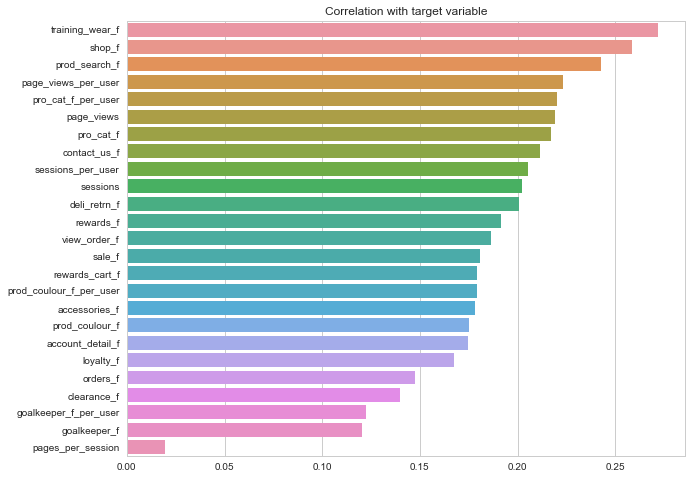

In [147]:
corr_with_target = df2.corr().iloc[1:, 0].sort_values(ascending=False)
xs = corr_with_target.values
ys = corr_with_target.index

plt.figure(figsize=(10, 8))

sns.barplot(x=xs, y=ys)

plt.title('Correlation with target variable')
plt.show()

4. обучить любой классификатор (какой вам нравится)

Протестируем Random Forest

In [156]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [157]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 33):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, 1.3, 1, 2])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [148]:
y = df2[target]
X = df2.drop(target, axis=1)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [161]:
parameters = {
    'n_estimators': [300, 400, 500],
    'max_features': np.arange(14, 18),
    'max_depth': np.arange(14, 18),
}

clf = GridSearchCV(
    estimator=RandomForestClassifier(criterion='entropy'),
    param_grid=parameters,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

In [162]:
%%time
clf.fit(X_train, y_train)

Wall time: 3min 33s


GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=-1,
             param_grid={'max_depth': array([14, 15, 16, 17]),
                         'max_features': array([14, 15, 16, 17]),
                         'n_estimators': [300, 400, 500]},
             scoring='f1')

In [163]:
clf.best_params_

{'max_depth': 17, 'max_features': 15, 'n_estimators': 500}

In [164]:
%%time
model_rfc = RandomForestClassifier(n_estimators = 500,
                                   max_depth = 17,
                                   criterion = 'entropy',
                                   max_features = 15,
                                   random_state = 42
                                  )
model_rfc.fit(X_train, y_train)

Wall time: 4.63 s


RandomForestClassifier(criterion='entropy', max_depth=17, max_features=15,
                       n_estimators=500, random_state=42)

TRAIN

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2260
           1       0.98      0.97      0.98       816

    accuracy                           0.99      3076
   macro avg       0.99      0.98      0.98      3076
weighted avg       0.99      0.99      0.99      3076

TEST

              precision    recall  f1-score   support

           0       0.84      0.89      0.87       752
           1       0.65      0.54      0.59       274

    accuracy                           0.80      1026
   macro avg       0.74      0.72      0.73      1026
weighted avg       0.79      0.80      0.79      1026

CONFUSION MATRIX

col_0     0    1
target          
0       670   82
1       125  149


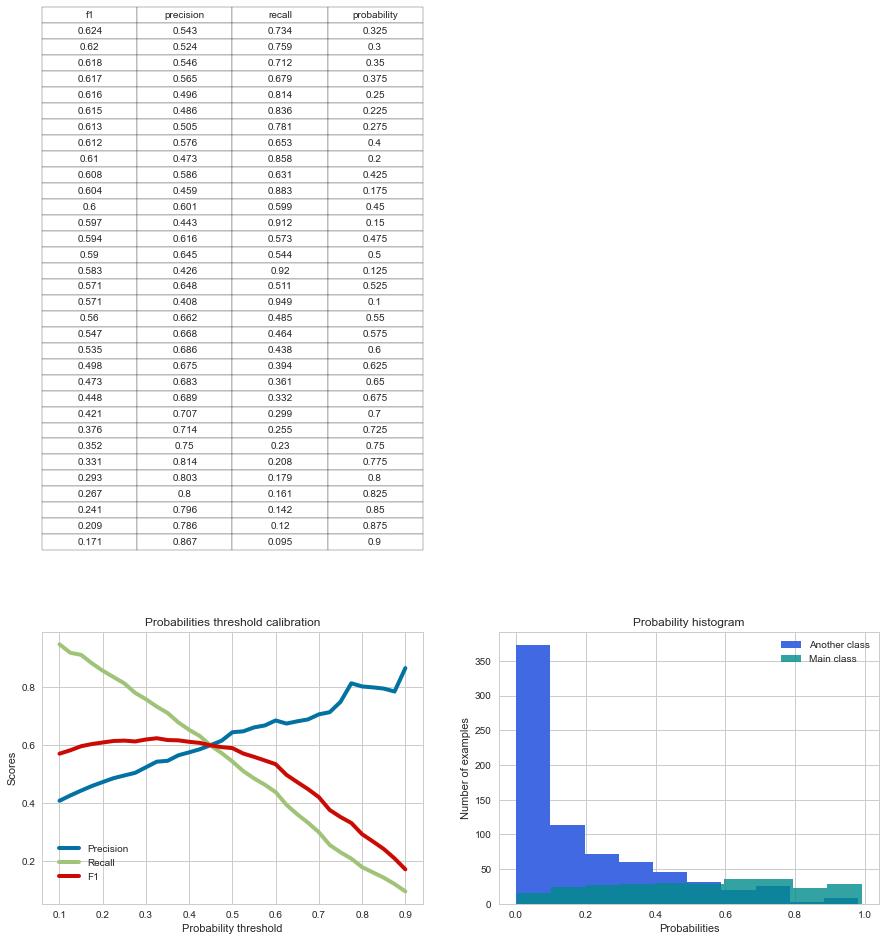

In [165]:
y_train_pred = model_rfc.predict(X_train)
y_test_pred = model_rfc.predict(X_test)
y_test_pred_probs = model_rfc.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [166]:
def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_test_pred)

Classification results:
f1: 59.01%
roc: 71.74%
recall: 54.38%
precision: 64.50%


5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [190]:
mod_data = df2.copy()
mod_data.head(10)

,target,account_detail_f,pro_cat_f,accessories_f,view_order_f,orders_f,contact_us_f,rewards_f,rewards_cart_f,deli_retrn_f,shop_f,prod_search_f,goalkeeper_f,loyalty_f,prod_coulour_f,clearance_f,sale_f,training_wear_f,page_views,sessions,pages_per_session,sessions_per_user,page_views_per_user,pro_cat_f_per_user,goalkeeper_f_per_user,prod_coulour_f_per_user
0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,10,1,10.000000,1,10,3,0,1
1,0,5,31,13,0,2,1,4,1,0,6,0,0,0,0,0,1,0,78,6,13.000000,6,78,31,0,0
2,0,3,24,0,0,1,0,0,0,0,19,0,2,0,4,3,2,3,86,6,14.333333,6,86,24,2,4
3,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,1,7.000000,1,7,0,0,0
4,1,18,129,2,10,10,0,26,1,1,172,2,3,21,1,0,0,86,454,25,18.160000,25,454,129,3,1
5,0,0,16,0,0,0,0,0,0,0,19,1,8,0,0,0,0,4,49,1,49.000000,1,49,16,8,0
6,1,65,170,3,16,24,2,24,7,1,132,5,4,0,46,1,6,66,636,26,24.461538,26,636,170,4,46
7,0,3,28,12,0,0,2,5,0,0,37,1,3,2,0,0,3,6,696,96,7.250000,96,696,28,3,0
8,0,1,8,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,14,1,14.000000,1,14,8,0,0
9,0,0,15,0,0,0,0,0,0,0,11,0,0,0,6,1,2,1,39,5,7.800000,5,39,15,0,6


In [191]:
#get the indices of the positives samples
pos_ind = np.where(mod_data[target].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 25% of the positives marked
pos_sample_len = int(np.ceil(0.25 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 273/1090 as positives and unlabeling the rest


In [192]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data[target].value_counts())

target variable:
 0    3012
1    1090
Name: target, dtype: int64


In [195]:
mod_data['class_test'].value_counts()

-1    3829
 1     273
Name: class_test, dtype: int64

In [200]:
x_data = mod_data[feauters].values # just the X 
y_labeled = mod_data['class_test'].values # new class (just the P & U)
y_positive = mod_data[target].values # original class

6. применить random negative sampling для построения классификатора в новых условиях

In [223]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])*3]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1])*3:]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(819, 27) (273, 27)


In [228]:
model_rns = xgb.XGBClassifier()

model_rns.fit(sample_train[feauters].values, 
          sample_train[target].values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [229]:
y_predict = model_rns.predict(sample_test[feauters].values)

In [230]:
evaluate_results(sample_test[target].values, y_predict)

Classification results:
f1: 57.64%
roc: 75.30%
recall: 69.98%
precision: 49.00%


7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [233]:
%%time
#gives model report in dataframe
def model_report(model, training_x, testing_x, training_y, testing_y,name, cols=None):
    if cols:
        training_x = training_x[cols]
        testing_x = testing_x[cols]
    model.fit(training_x, training_y)
    predictions  = model.predict(testing_x)
    accuracy     = accuracy_score(testing_y,predictions)
    recallscore  = recall_score(testing_y,predictions)
    precision    = precision_score(testing_y,predictions)
    roc_auc      = roc_auc_score(testing_y,predictions)
    f1score      = f1_score(testing_y,predictions) 
    kappa_metric = cohen_kappa_score(testing_y,predictions)
    
    df = pd.DataFrame({"Model"           : [name],
                       "Accuracy_score"  : [accuracy],
                       "Recall_score"    : [recallscore],
                       "Precision"       : [precision],
                       "f1_score"        : [f1score],
                       "Area_under_curve": [roc_auc],
                       "Kappa_metric"    : [kappa_metric],
                      })
    return df

#outputs for every model
model1 = model_report(model_rfc, X_train, X_test, y_train, y_test,
                      "Random Forest Classifier")

model2 = model_report(model_rns, sample_train[feauters].values, sample_test[feauters].values, 
                      sample_train[target].values, sample_test[target].values,
                      "XGB with random negative sampling")

#concat all models
model_performances = pd.concat([model1, model2], axis=0).reset_index()

model_performances = model_performances.drop("index", axis=1)

Wall time: 4.93 s


In [234]:
model_performances

,Model,Accuracy_score,Recall_score,Precision,f1_score,Area_under_curve,Kappa_metric
0,Random Forest Classifier,0.798246,0.543796,0.645022,0.590099,0.717377,0.457575
1,XGB with random negative sampling,0.783721,0.699842,0.490044,0.576448,0.752950,0.437231


__Качество предсказания модели Random Forest Classifier было слабым, но модель XGBoost с random negative sampling не сильно ухудшилась__ 

# Домашнее задание (часть 2)

1. Придумать новые признаки (у нас их всего 5 было) - сделать дополнительный feature engineering

In [548]:
# Чтение данных
df_clients = pd.read_csv('./uplift_data/clients.csv', index_col='client_id')
df_train = pd.read_csv('./uplift_data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('./uplift_data/uplift_test.csv', index_col='client_id')

In [475]:
df_train.head()

,treatment_flg,target
client_id,,
000012768d,0,1
000036f903,1,1
00010925a5,1,1
0001f552b0,1,1
00020e7b18,1,1


In [476]:
df_clients.head()

,first_issue_date,first_redeem_date,age,gender
client_id,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
000048b7a6,2018-12-15 13:33:11,NaN,68,F
000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60,F
00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67,U


Почистим данные:

In [479]:
#Обнулим возраст пользователей младше 11 - таких не очень много
df_clients.loc[df_clients['age'] < 11].shape

(416, 4)

In [549]:
df_clients.loc[df_clients['age'] < 11, 'age'] = np.nan

In [481]:
#И также обнулим возраст пользователей старше 110
df_clients.loc[df_clients['age'] > 110].shape

(1032, 4)

In [550]:
df_clients.loc[df_clients['age'] > 110, 'age'] = np.nan

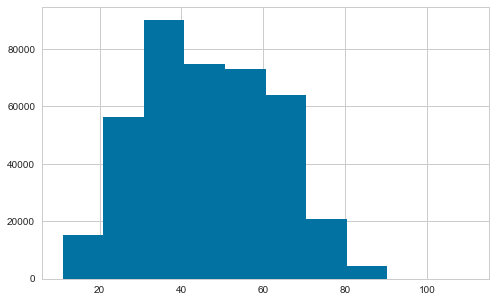

In [483]:
df_clients['age'].hist(bins=10)

Добавим признаки:
- день недели
- день месяца
- номер недели
- месяц
- год

In [551]:
df_clients['first_issue_date'] = pd.to_datetime(df_clients['first_issue_date'])
df_clients['first_redeem_date'] = pd.to_datetime(df_clients['first_redeem_date'])

df_clients['first_issue_year'] = df_clients['first_issue_date'].dt.year
df_clients['first_issue_month'] = df_clients['first_issue_date'].dt.month
df_clients['first_issue_week'] = df_clients['first_issue_date'].dt.week
df_clients['first_issue_day'] = df_clients['first_issue_date'].dt.day
df_clients['first_issue_dayofweek'] = df_clients['first_issue_date'].dt.dayofweek

df_clients['first_redeem_year'] = df_clients['first_redeem_date'].dt.year
df_clients['first_redeem_month'] = df_clients['first_redeem_date'].dt.month
df_clients['first_redeem_week'] = df_clients['first_redeem_date'].dt.week
df_clients['first_redeem_day'] = df_clients['first_redeem_date'].dt.day
df_clients['first_redeem_dayofweek'] = df_clients['first_redeem_date'].dt.dayofweek

- возрастные группы

In [552]:
bins = [0, 18, 23, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 100, 120]
df_clients['age_group'] = pd.cut(df_clients['age'], bins, labels=bins[1:]).astype('str')

- курс доллара по датам first_issue_date и first_redeem_date

In [553]:
df_clients.reset_index(level=0, inplace=True)
df_clients.head()

,client_id,first_issue_date,first_redeem_date,age,gender,first_issue_year,first_issue_month,first_issue_week,first_issue_day,first_issue_dayofweek,first_redeem_year,first_redeem_month,first_redeem_week,first_redeem_day,first_redeem_dayofweek,age_group
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,U,2017,8,31,5,5,2018.0,1.0,1.0,4.0,3.0,45.0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72.0,F,2017,4,15,10,0,2017.0,4.0,16.0,23.0,6.0,75.0
2,000048b7a6,2018-12-15 13:33:11,NaT,68.0,F,2018,12,50,15,5,NaN,NaN,NaN,NaN,NaN,70.0
3,000073194a,2017-05-23 12:56:14,2017-11-24 11:18:01,60.0,F,2017,5,21,23,1,2017.0,11.0,47.0,24.0,4.0,60.0
4,00007c7133,2017-05-22 16:17:08,2018-12-31 17:17:33,67.0,U,2017,5,21,22,0,2018.0,12.0,1.0,31.0,0.0,70.0


In [554]:
with open('./uplift_data/dollar.json') as json_file:
    data = json.load(json_file)

df_dollar = pd.DataFrame(data)
df_dollar['date'] =  pd.to_datetime(df_dollar['date'], format='%Y-%m-%d')
df_dollar = df_dollar.loc[df_dollar['date'] > pd.to_datetime('2016-12-31')]

In [555]:
df_clients['date'] = pd.to_datetime(df_clients['first_issue_date'].dt.date, format='%Y-%m-%d')
df_clients2 = pd.merge(df_clients, df_dollar, on='date', how='inner')

In [556]:
df_clients2['date'] = pd.to_datetime(df_clients2['first_redeem_date'].dt.date, format='%Y-%m-%d')
df_clients3 = pd.merge(df_clients2, df_dollar, on='date', how='left')

In [558]:
df_clients3.shape

(400162, 19)

In [559]:
df_clients3.rename(columns={'value_x':'first_issue_dollar', 'value_y':'first_redeem_dollar'}, inplace=True)
df_clients3.drop('date', axis=1, inplace=True)
df_clients3.set_index('client_id', inplace=True)
df_clients3.head()

,first_issue_date,first_redeem_date,age,gender,first_issue_year,first_issue_month,first_issue_week,first_issue_day,first_issue_dayofweek,first_redeem_year,first_redeem_month,first_redeem_week,first_redeem_day,first_redeem_dayofweek,age_group,first_issue_dollar,first_redeem_dollar
client_id,,,,,,,,,,,,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45.0,U,2017,8,31,5,5,2018.0,1.0,1.0,4.0,3.0,45.0,60.3281,57.6002
000f064b75,2017-08-05 12:03:12,2017-11-24 14:27:21,29.0,F,2017,8,31,5,5,2017.0,11.0,47.0,24.0,4.0,30.0,60.3281,58.4622
001baafea0,2017-08-05 12:30:45,2018-06-04 15:22:42,62.0,F,2017,8,31,5,5,2018.0,6.0,23.0,4.0,0.0,65.0,60.3281,62.2056
003b78bd6a,2017-08-05 14:30:57,2017-12-28 19:20:18,69.0,U,2017,8,31,5,5,2017.0,12.0,52.0,28.0,3.0,70.0,60.3281,57.4544
006d47ff8a,2017-08-05 13:46:28,2017-09-30 08:47:36,31.0,F,2017,8,31,5,5,2017.0,9.0,39.0,30.0,5.0,35.0,60.3281,58.0169


- основные праздничные и предпраздничные дни 

In [560]:
holidays_day_of_month = [
    [1, 2, 3, 4, 5, 6, 7, 8],
    [14],
    [8],
    [],
    [1, 2, 3, 8, 9, 10],
    [],
    [],
    [],
    [],
    [],
    [],
    [31]
]
pre_holidays_day_of_month = [
    [],
    [13],
    [5, 6, 7],
    [30],
    [7],
    [],
    [],
    [],
    [],
    [],
    [],
    [25, 26, 27, 28, 29, 30]
]

In [561]:
df_clients3['first_issue_holiday'] = 0
df_clients3['first_issue_preholiday'] = 0
df_clients3['first_redeem_holiday'] = 0
df_clients3['first_redeem_preholiday'] = 0

for m in range(12):
    month = m + 1
    if len(holidays_day_of_month[m]):
        for v in holidays_day_of_month[m]:
            df_clients3.loc[(df_clients3['first_issue_month'] == month) & (df_clients3['first_issue_day'] == v)
                            , 'first_issue_holiday'] = 1
            df_clients3.loc[(df_clients3['first_redeem_month'] == month) & (df_clients3['first_redeem_day'] == v)
                            , 'first_redeem_holiday'] = 1
    
    if len(pre_holidays_day_of_month[m]):
        for v in holidays_day_of_month[m]:
            df_clients3.loc[(df_clients3['first_issue_month'] == month) & (df_clients3['first_issue_day'] == v)
                            , 'first_issue_preholiday'] = 1
            df_clients3.loc[(df_clients3['first_redeem_month'] == month) & (df_clients3['first_redeem_day'] == v)
                            , 'first_redeem_preholiday'] = 1

In [562]:
df_clients3.shape

(400162, 21)

Добавим признаки с урока:

In [563]:
# Извлечение признаков
df_features = df_clients3.copy()
df_features['first_issue_time'] = (df_features['first_issue_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['first_redeem_time'] = (df_features['first_redeem_date'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df_features['issue_redeem_delay'] = df_features['first_redeem_time'] - df_features['first_issue_time']
df_features = df_features.drop(['first_issue_date', 'first_redeem_date'], axis=1)

In [564]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, 
                                                test_size=0.4, 
                                                random_state=12)

2. Для подходов с одной моделью поварьировать параметры CatBoostClassifier либо даже попробовать другой алгоритм (опционально уже).

In [739]:
models_results = {
    'approach': [],
    'uplift@30%': [],
    'ctrl_log_loss': [],
    'ctrl_f1_score': [],
    'ctrl_roc_auc': [],
    'ctrl_accuracy': [],
}

In [740]:
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features.loc[indices_test, :]

In [741]:
cat_features = ['gender', 'age_group']

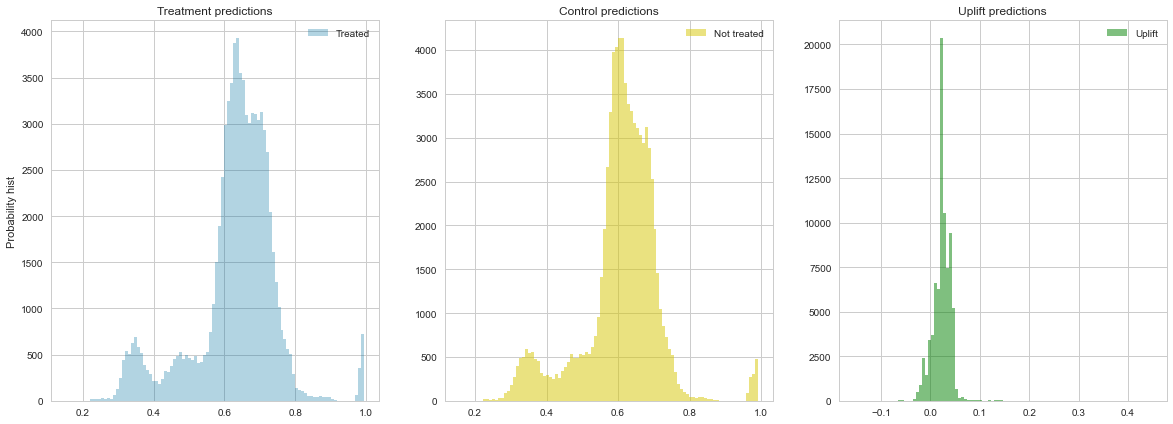

In [742]:
sm_catb = SoloModel(catb.CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm_catb = sm_catb.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm_catb.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_catb.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_catb.ctrl_preds_

sm_ctrl_y_pred = [0 if x<0.5 else 1 for x in sm_ctrl_preds]

models_results['approach'].append('SoloModel CatB')
models_results['uplift@30%'].append(sm_score)
models_results['ctrl_log_loss'].append(log_loss(y_val, sm_ctrl_preds))
models_results['ctrl_f1_score'].append(f1_score(y_val, sm_ctrl_y_pred))
models_results['ctrl_roc_auc'].append(roc_auc_score(y_val, sm_ctrl_preds))
models_results['ctrl_accuracy'].append(accuracy_score(y_val, sm_ctrl_y_pred))

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [743]:
models_results

{'approach': ['SoloModel CatB'],
 'uplift@30%': [0.041065306968323445],
 'ctrl_log_loss': [0.6372268586826665],
 'ctrl_f1_score': [0.7642299526921985],
 'ctrl_roc_auc': [0.6151256821623747],
 'ctrl_accuracy': [0.6474705058988203]}

In [744]:
#важность признаков:
sm_fi1 = pd.DataFrame({
    'feature_name': sm_catb.estimator.feature_names_,
    'feature_score': sm_catb.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi1

,feature_name,feature_score
0,first_redeem_dollar,31.272396
1,first_redeem_week,22.481867
2,first_redeem_time,15.200357
3,first_redeem_month,10.137632
4,issue_redeem_delay,5.445447
5,age,4.114131
6,first_issue_time,2.421105
7,gender,1.500821
8,first_redeem_day,1.475320
9,treatment,1.457391


Удалим совсем не важные признаки и попробуем XGBoost

In [745]:
df_features2 = df_features.drop(['age_group', 'first_issue_holiday', 'first_redeem_holiday'], axis=1)

In [746]:
df_features2 = pd.get_dummies(df_features2)

In [747]:
df_features2.head()

,age,first_issue_year,first_issue_month,first_issue_week,first_issue_day,first_issue_dayofweek,first_redeem_year,first_redeem_month,first_redeem_week,first_redeem_day,first_redeem_dayofweek,first_issue_dollar,first_redeem_dollar,first_issue_preholiday,first_redeem_preholiday,first_issue_time,first_redeem_time,issue_redeem_delay,gender_F,gender_M,gender_U
client_id,,,,,,,,,,,,,,,,,,,,,
000012768d,45.0,2017,8,31,5,5,2018.0,1.0,1.0,4.0,3.0,60.3281,57.6002,0,0,1501947648,1.515094e+09,13146559.0,0,0,1
000f064b75,29.0,2017,8,31,5,5,2017.0,11.0,47.0,24.0,4.0,60.3281,58.4622,0,0,1501934592,1.511534e+09,9599049.0,1,0,0
001baafea0,62.0,2017,8,31,5,5,2018.0,6.0,23.0,4.0,0.0,60.3281,62.2056,0,0,1501936245,1.528126e+09,26189517.0,1,0,0
003b78bd6a,69.0,2017,8,31,5,5,2017.0,12.0,52.0,28.0,3.0,60.3281,57.4544,0,0,1501943457,1.514489e+09,12545361.0,0,0,1
006d47ff8a,31.0,2017,8,31,5,5,2017.0,9.0,39.0,30.0,5.0,60.3281,58.0169,0,0,1501940788,1.506761e+09,4820468.0,1,0,0


In [748]:
X_train = df_features2.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features2.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features2.loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features2.loc[indices_test, :]

Wall time: 3min 24s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000019303ED0848>,
      dtype=object)

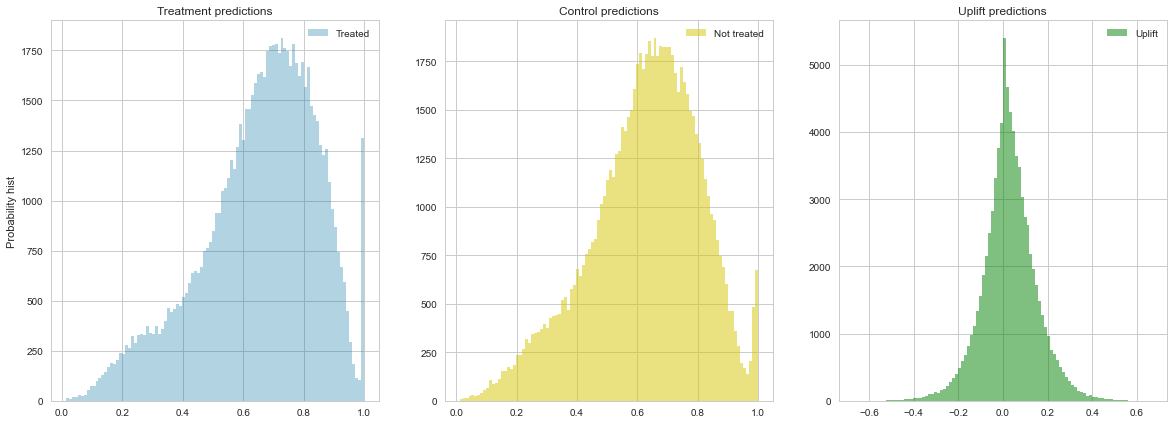

In [749]:
%%time
sm_xgb = SoloModel(xgb.XGBClassifier(n_estimators=400, max_depth=20,
                                 learning_rate=0.05, random_state=42))
sm_xgb = sm_xgb.fit(X_train, y_train, treat_train)

uplift_sm = sm_xgb.predict(X_val)

sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm_xgb.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm_xgb.ctrl_preds_

sm_ctrl_y_pred = [0 if x<0.5 else 1 for x in sm_ctrl_preds]

models_results['approach'].append('SoloModel XGB')
models_results['uplift@30%'].append(sm_score)
models_results['ctrl_log_loss'].append(log_loss(y_val, sm_ctrl_preds))
models_results['ctrl_f1_score'].append(f1_score(y_val, sm_ctrl_y_pred))
models_results['ctrl_roc_auc'].append(roc_auc_score(y_val, sm_ctrl_preds))
models_results['ctrl_accuracy'].append(accuracy_score(y_val, sm_ctrl_y_pred))

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [750]:
models_results

{'approach': ['SoloModel CatB', 'SoloModel XGB'],
 'uplift@30%': [0.041065306968323445, 0.02235046082618508],
 'ctrl_log_loss': [0.6372268586826665, 0.6846146447872813],
 'ctrl_f1_score': [0.7642299526921985, 0.71966256842861],
 'ctrl_roc_auc': [0.6151256821623747, 0.579514840850421],
 'ctrl_accuracy': [0.6474705058988203, 0.6096030793841232]}

In [751]:
#важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm_xgb.estimator.get_booster().feature_names,
    'feature_score': sm_xgb.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,first_redeem_time,0.077225
1,first_redeem_preholiday,0.057094
2,issue_redeem_delay,0.052432
3,first_redeem_dollar,0.051315
4,first_issue_preholiday,0.050485
5,first_issue_time,0.048735
6,first_issue_dollar,0.047768
7,gender_M,0.047279
8,first_redeem_week,0.047118
9,first_issue_week,0.046437


Модель с трансформацией классов

In [752]:
top20_feauters_name = sm_fi1.head(20)['feature_name'].to_list()
top20_feauters_name.remove('treatment')
cat_features = ['gender']

In [753]:
X_train = df_features[top20_feauters_name].loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'target']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features[top20_feauters_name].loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

X_train_full = df_features[top20_feauters_name].loc[indices_train, :]
y_train_full = df_train.loc[:, 'target']
treat_train_full = df_train.loc[:, 'treatment_flg']

X_test = df_features[top20_feauters_name].loc[indices_test, :]

Подобрал параметры, показывающие наибольший аплифт с ТОП20 признаками по модели из предыдущего метода

In [754]:
%%time
ct = ClassTransformation(catb.CatBoostClassifier(
    iterations=5, 
    thread_count=2, 
    learning_rate=0.5, 
    l2_leaf_reg=3,
    loss_function='CrossEntropy',
    random_state=42, 
    silent=True
))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation CatB')
models_results['uplift@30%'].append(ct_score)
models_results['ctrl_log_loss'].append('-')
models_results['ctrl_f1_score'].append('-')
models_results['ctrl_roc_auc'].append('-')
models_results['ctrl_accuracy'].append('-')

Wall time: 358 ms


In [755]:
models_results

{'approach': ['SoloModel CatB', 'SoloModel XGB', 'ClassTransformation CatB'],
 'uplift@30%': [0.041065306968323445,
  0.02235046082618508,
  0.062286698447055144],
 'ctrl_log_loss': [0.6372268586826665, 0.6846146447872813, '-'],
 'ctrl_f1_score': [0.7642299526921985, 0.71966256842861, '-'],
 'ctrl_roc_auc': [0.6151256821623747, 0.579514840850421, '-'],
 'ctrl_accuracy': [0.6474705058988203, 0.6096030793841232, '-']}

In [704]:
pd.DataFrame({
    'feature_name': ct.estimator.feature_names_,
    'feature_score': ct.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

,feature_name,feature_score
0,first_redeem_time,31.589894
1,first_redeem_month,24.796242
2,first_redeem_day,14.921686
3,first_redeem_dayofweek,8.450034
4,first_redeem_week,6.214532
5,first_issue_month,3.358664
6,age,3.357834
7,first_issue_time,2.388034
8,first_issue_day,1.332955
9,first_issue_dayofweek,1.116354


3. Для пункта 2 (подходов на основе одной модели) вывести значимость признаков, основываясь на 
model.estimator.feature_importances_ и model.estimator.feature_names_.

Вывел выше

4. Дополнить models_results дополнительными метриками (roc auc, logloss, f1). В конце вывести сводную таблицу всех показателей для всех подходов (как на основе

In [761]:
pd.DataFrame(models_results).sort_values(by='uplift@30%', ascending=False)

,approach,uplift@30%,ctrl_log_loss,ctrl_f1_score,ctrl_roc_auc,ctrl_accuracy
2,ClassTransformation CatB,0.062287,-,-,-,-
0,SoloModel CatB,0.041065,0.637227,0.76423,0.615126,0.647471
1,SoloModel XGB,0.022350,0.684615,0.719663,0.579515,0.609603


#### Наилучший результат показала модель ClassTransformation с CatBoost, подобранными параметрами и ТОП20 фичами, подобранными из предыдущей модели. Но по ней я не смог собрать дополнительные метрики, поскольку модель выдает только значение аплифта.
#### Также не до конца мне понятно, по какому предсказанному значению собирать метрики качества - по предсказанным данным на пользователях, с какими не было взаимодействие, или по тем, с кем было взаимодействие?  